#### Calculo de CrossCorrelation Bright/Faint vs UHECRs - TreeCorr

In [1]:
def generate_RandomCatalogue(ra,dec,nmult,seed):
    
    np.random.seed(seed)

    ra_min = np.min(ra)
    ra_max = np.max(ra)
    dec_min = np.min(dec)
    dec_max = np.max(dec)

    rand_ra = np.random.uniform(ra_min, ra_max, len(ra)*nmult)
    rand_sindec = np.random.uniform(np.sin(dec_min*np.pi/180.), np.sin(dec_max*np.pi/180.), \
                                    len(ra)*nmult)
    rand_dec = np.arcsin(rand_sindec)*180./np.pi

    return rand_ra, rand_dec

######################
minsep = 10.
maxsep = 90.
nbins = 15
nmult = 10

seed1 = 12936
seed2 = 19284

config = {"min_sep": minsep, "max_sep": maxsep, "nbins": nbins, "sep_units": 'degree', \
          "bin_type": 'Linear', "brute": True, "metric": 'Arc'}
######################

from astropy.io import ascii
import numpy as np

# Read UHECR
filename_e = '../data/Auger/events_a8_lb.dat'
#events_a8 = ascii.read(filename_e)

# Read Gxs
filename_g = '../data/VLS/2MRSxWISE_VLS.txt'
data = ascii.read(filename_g)

# Bright/Faint
data_bright = data[(data['K_abs']<-23.2)&(data['K_abs']>-26.)]
data_faint = data[(data['K_abs']>-23.2)&(data['K_abs']<-22.)]

# Random Catalogue
rand_ra1, rand_dec1 = generate_RandomCatalogue(data_bright['_RAJ2000'],data_bright['_DEJ2000'],\
                                               nmult,seed1)
rand_ra2, rand_dec2 = generate_RandomCatalogue(data_faint['_RAJ2000'],data_faint['_DEJ2000'],\
                                               nmult,seed2)

"""
BRIGHT
"""
# TreeCorr Catalogues
import treecorr

gcat = treecorr.Catalog(ra=data_bright['_RAJ2000'], dec=data_bright['_DEJ2000'],ra_units='deg', dec_units='deg')
ecat = treecorr.Catalog(filename_e, ra_col='RA', dec_col='dec', ra_units='deg', dec_units='deg')
rcat1 = treecorr.Catalog(ra=rand_ra1, dec=rand_dec1, ra_units='deg', dec_units='deg')
rcat2 = treecorr.Catalog(ra=rand_ra2, dec=rand_dec2, ra_units='deg', dec_units='deg')


dd = treecorr.NNCorrelation(config)
dr = treecorr.NNCorrelation(config)
rr = treecorr.NNCorrelation(config)
rd = treecorr.NNCorrelation(config)

rr.process(rcat1)
dd.process(gcat,ecat)
dr.process(gcat,rcat1)
rd.process(ecat,rcat1)

xi1, varxi1 = dd.calculateXi(rr=rr,dr=dr,rd=rd)


"""
FAINT
"""
gcat = treecorr.Catalog(ra=data_faint['_RAJ2000'], dec=data_faint['_DEJ2000'],\
                        ra_units='deg', dec_units='deg')
ecat = treecorr.Catalog(filename_e, ra_col='RA', dec_col='dec', ra_units='deg', dec_units='deg')
rcat1 = treecorr.Catalog(ra=rand_ra1, dec=rand_dec1, ra_units='deg', dec_units='deg')
rcat2 = treecorr.Catalog(ra=rand_ra2, dec=rand_dec2, ra_units='deg', dec_units='deg')

config = {"min_sep": minsep, "max_sep": maxsep, "nbins": nbins, "sep_units": 'degree', \
          "bin_type": 'Linear', "brute": False, "metric": 'Arc'}

dd = treecorr.NNCorrelation(config)
dr = treecorr.NNCorrelation(config)
rr = treecorr.NNCorrelation(config)
rd = treecorr.NNCorrelation(config)

rr.process(rcat2)
dd.process(gcat,ecat)
dr.process(gcat,rcat2)
rd.process(ecat,rcat2)

xi2, varxi2 = dd.calculateXi(rr=rr,dr=dr,rd=rd)

#### Plot

[0.00682704 0.00578106 0.00513759 0.00469669 0.00437731 0.00413559
 0.00395065 0.00380917 0.00369767 0.00361127 0.00354843 0.00350157
 0.00347304 0.00345892 0.00345553] [0.00700533 0.00589541 0.00522028 0.00480938 0.00448284 0.0042154
 0.00403975 0.00389858 0.00377523 0.00370113 0.00362394 0.00357901
 0.00355093 0.00353908 0.00353867]


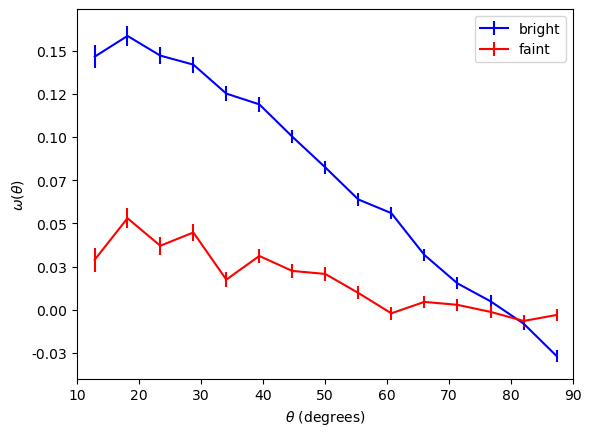

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()

sig1 = np.sqrt(varxi1)
sig2 = np.sqrt(varxi2)
print(sig1,sig2)
r = np.exp(dd.meanlogr)
r = dd.meanr

ax.errorbar(r, xi1, yerr=sig1, color='blue', label='bright')
ax.errorbar(r, xi2, yerr=sig2, color='red', label='faint')

ax.legend()

ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$\omega(\theta)$')

ax.set_xlim([minsep,maxsep])

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.savefig(f'../data/cross_treecorr_bf_{nmult}.png')
plt.show()


#### Write

In [3]:
np.savez(f'../data/treecorr_cross_bright_{nmult}.npz',r,xi1,sig1)
np.savez(f'../data/treecorr_cross_faint_{nmult}.npz',r,xi2,sig2)